In [64]:
# Librerías

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import string # string manipulation
import re # regular expressions
import nltk # text manipulation
nltk.download('punkt')
nltk.download('stopwords')

from tqdm import trange # progress bar
from nltk import tokenize # text manipulation
from nltk.corpus import stopwords # text manipulation
from nltk.stem import WordNetLemmatizer # text manipulation
from nltk.probability import FreqDist # text manipulation
from collections import Counter # text manipulation
from sklearn.feature_extraction.text import CountVectorizer # text manipulation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # wordcloud generator
from IPython.display import display # image display
from PIL import Image

#hito 2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree

import joblib # guardar modelos

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocesamiento

In [65]:
data = pd.read_csv("threads.csv") # carga del dataset a usar como variable

In [66]:
# función para convertir el rating a palabras
def ratingTransform(rating):
    if rating <= 2:
        return "NEGATIVE"
    elif rating <= 4:
        return "NEUTRAL"
    else:
        return "POSITIVE"

# creacion del grafico de pie de las reviews segun rating
data["rating"] = data["rating"].apply(ratingTransform)

In [67]:
def clean(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

data['review_description'] = data['review_description'].apply(clean)

In [68]:
Y = data['rating']

In [69]:
def oversampling(X,y):
    ros = RandomOverSampler(random_state=42)
    X_resample, y_resample = ros.fit_resample(X, y)
    return (X_resample, y_resample)

## 1-gram

In [52]:
vectorizer = CountVectorizer(min_df=0.0005)
vectors = vectorizer.fit_transform(data["review_description"])
joblib.dump(vectorizer.get_feature_names_out(), "modelos/1-gram_vectorizer.pkl")

['modelos/1-gram_vectorizer.pkl']

In [23]:
vectorized = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
X_1gram = vectorized

In [24]:
X_1gram, y1 = oversampling(X_1gram, Y)

In [25]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_1gram, y1, test_size=0.33, random_state=37,stratify=y1)
joblib.dump(X1_train, 'modelos/X1_train.pkl')
joblib.dump(X1_test, 'modelos/X1_test.pkl')
joblib.dump(y1_train, 'modelos/y1_train.pkl')
joblib.dump(y1_test, 'modelos/y1_test.pkl')

['modelos/y1_test.pkl']

### Entrenar Modelos

In [15]:
X1_train = joblib.load('modelos/X1_train.pkl')
y1_train = joblib.load('modelos/y1_train.pkl')

In [35]:
clf = DecisionTreeClassifier()
clf.fit(X1_train, y1_train) 
joblib.dump(clf, "modelos/1-gram_trained_DecisionTreeClassifier.joblib")

['modelos/1-gram_trained_DecisionTreeClassifier.joblib']

In [36]:
clf = MultinomialNB()
clf.fit(X1_train, y1_train)
joblib.dump(clf, "modelos/1-gram_trained_NV.joblib")

['modelos/1-gram_trained_NV.joblib']

In [37]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X1_train, y1_train)
joblib.dump(clf, "modelos/1-gram_logistic_regesion.joblib")

['modelos/1-gram_logistic_regesion.joblib']

In [4]:
clf = SVC()
clf.fit(X1_train, y1_train)
joblib.dump(clf, "modelos/1-gram_trained_svc.joblib")

### Cargar modelos para evaluar

In [2]:
X1_test = joblib.load('modelos/X1_test.pkl')
y1_test = joblib.load('modelos/y1_test.pkl')

In [38]:
clf = joblib.load("modelos/1-gram_trained_DecisionTreeClassifier.joblib")
y1_pred = clf.predict(X1_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y1_test, y1_pred))   ## Evaluamos la predicción comparando y_test con y1_pred
print(classification_report(y1_test, y1_pred))

Accuracy en test set: 0.7289665022072189
              precision    recall  f1-score   support

    NEGATIVE       0.81      0.73      0.77      5135
     NEUTRAL       0.74      0.70      0.72      5135
    POSITIVE       0.65      0.76      0.70      5134

    accuracy                           0.73     15404
   macro avg       0.74      0.73      0.73     15404
weighted avg       0.74      0.73      0.73     15404



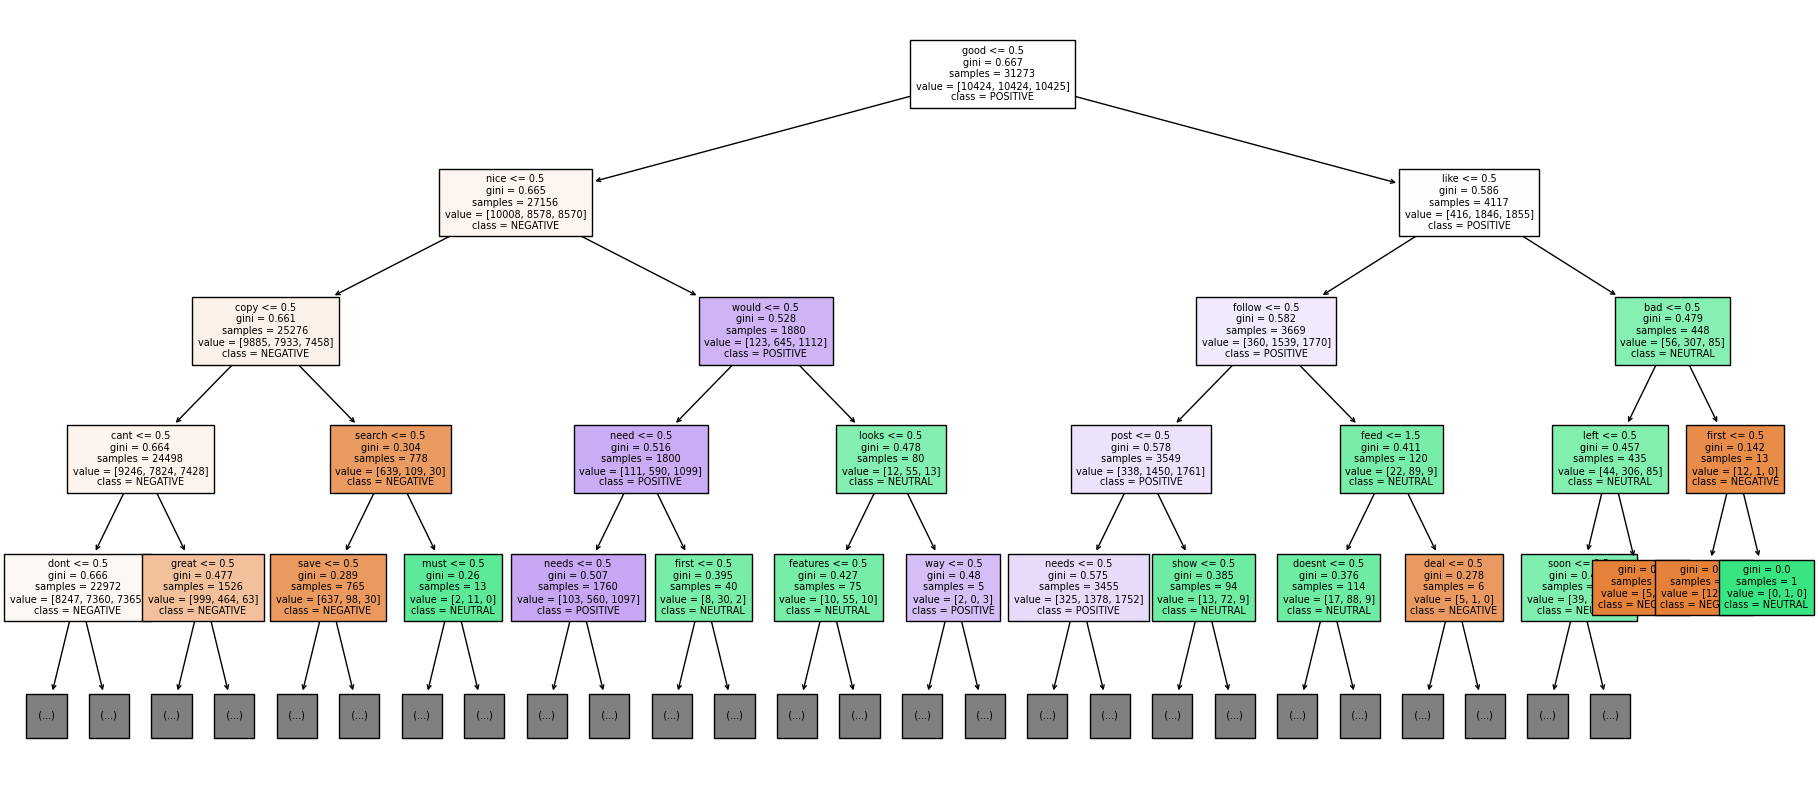

In [39]:
vectorizer = joblib.load("modelos/1-gram_vectorizer.pkl")
plt.figure(figsize=(23,10))
tree.plot_tree(decision_tree=clf, fontsize=7, max_depth = 4, feature_names=vectorizer,  class_names=clf.classes_, filled=True)
plt.show()

In [40]:
clf = joblib.load("modelos/1-gram_trained_NV.joblib")
y1_pred = clf.predict(X1_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y1_test, y1_pred))   ## Evaluamos la predicción comparando y_test con y1_pred
print(classification_report(y1_test, y1_pred))

Accuracy en test set: 0.6627499350817969
              precision    recall  f1-score   support

    NEGATIVE       0.76      0.67      0.72      5135
     NEUTRAL       0.67      0.45      0.54      5135
    POSITIVE       0.60      0.86      0.70      5134

    accuracy                           0.66     15404
   macro avg       0.68      0.66      0.65     15404
weighted avg       0.68      0.66      0.65     15404



In [41]:
clf = joblib.load("modelos/1-gram_logistic_regesion.joblib")
y1_pred = clf.predict(X1_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y1_test, y1_pred))   ## Evaluamos la predicción comparando y_test con y1_pred
print(classification_report(y1_test, y1_pred))

Accuracy en test set: 0.6769021033497793
              precision    recall  f1-score   support

    NEGATIVE       0.77      0.70      0.73      5135
     NEUTRAL       0.69      0.49      0.57      5135
    POSITIVE       0.61      0.84      0.71      5134

    accuracy                           0.68     15404
   macro avg       0.69      0.68      0.67     15404
weighted avg       0.69      0.68      0.67     15404



In [3]:
clf = joblib.load("modelos/1-gram_trained_svc.joblib")
y1_pred = clf.predict(X1_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y1_test, y1_pred))   ## Evaluamos la predicción comparando y_test con y1_pred
print(classification_report(y1_test, y1_pred))

c:\Users\Dani\anaconda3\envs\mineria\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 2-gram

In [51]:
cv = CountVectorizer(ngram_range=(2,2), min_df=0.00005)
bigrams = cv.fit_transform(data['review_description'])
joblib.dump(cv.get_feature_names_out(), "modelos/2-gram_vectorizer.pkl")

['modelos/2-gram_vectorizer.pkl']

In [53]:
bigrams = pd.DataFrame(bigrams.toarray(), columns=cv.get_feature_names_out())
X_2gram = bigrams

In [54]:
X_2gram, y2 = oversampling(X_2gram, Y)

In [55]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2gram, y2, test_size=0.33, random_state=37,stratify=y2)
joblib.dump(X2_train, 'modelos/X2_train.pkl')
joblib.dump(X2_test, 'modelos/X2_test.pkl')
joblib.dump(y2_train, 'modelos/y2_train.pkl')
joblib.dump(y2_test, 'modelos/y2_test.pkl')

['modelos/y2_test.pkl']

### Entrenar Modelos

In [63]:
X2_train = joblib.load('modelos/X2_train.pkl')
y2_train = joblib.load('modelos/y2_train.pkl')

In [56]:
clf = DecisionTreeClassifier()
clf.fit(X2_train, y2_train) 
joblib.dump(clf, "modelos/2-gram_trained_DecisionTreeClassifier.joblib")

['modelos/2-gram_trained_DecisionTreeClassifier.joblib']

In [57]:
clf = MultinomialNB()
clf.fit(X2_train, y2_train)
joblib.dump(clf, "modelos/2-gram_trained_NV.joblib")

['modelos/2-gram_trained_NV.joblib']

In [58]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X2_train, y2_train)
joblib.dump(clf, "modelos/2-gram_logistic_regesion.joblib")

['modelos/2-gram_logistic_regesion.joblib']

In [ ]:
clf = SVC()
clf.fit(X2_train, y2_train)
joblib.dump(clf, "modelos/2-gram_trained_svc.joblib")

### Cargar modelos para evaluar

In [56]:
X2_test = joblib.load('modelos/X2_test.pkl')
y2_test = joblib.load('modelos/y2_test.pkl')

In [59]:
clf = joblib.load("modelos/2-gram_trained_DecisionTreeClassifier.joblib")
y2_pred = clf.predict(X2_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y2_test, y2_pred))   ## Evaluamos la predicción comparando y2_test con y2_pred
print(classification_report(y2_test, y2_pred))

Accuracy en test set: 0.6913788626330823
              precision    recall  f1-score   support

    NEGATIVE       0.86      0.58      0.69      5135
     NEUTRAL       0.80      0.63      0.71      5135
    POSITIVE       0.56      0.86      0.68      5134

    accuracy                           0.69     15404
   macro avg       0.74      0.69      0.69     15404
weighted avg       0.74      0.69      0.69     15404



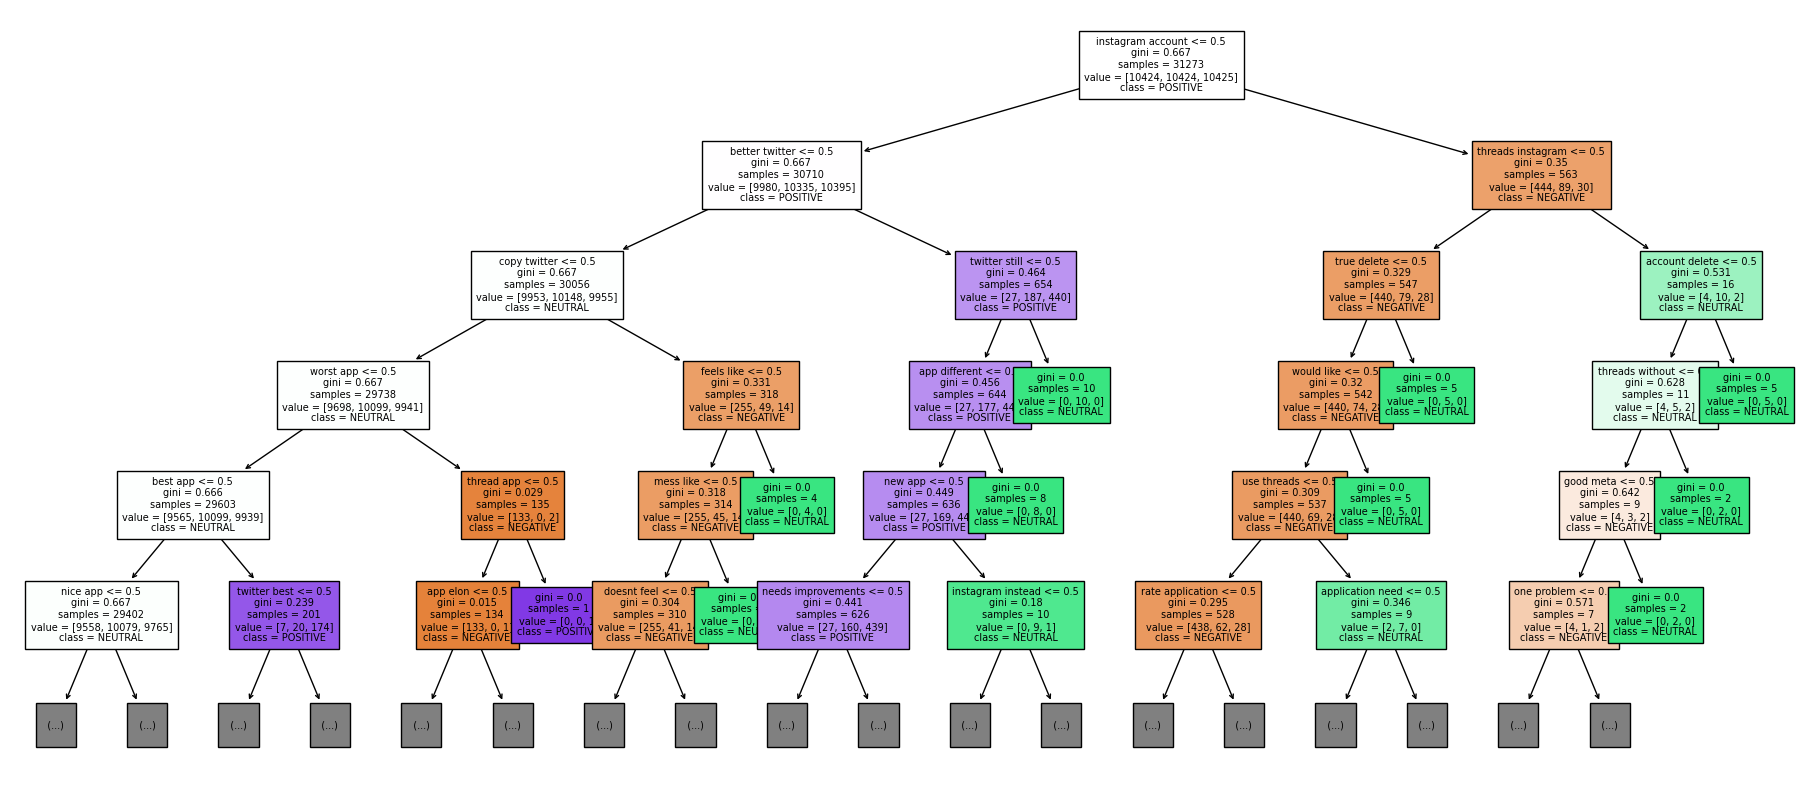

In [61]:
vectorizer = joblib.load("modelos/2-gram_vectorizer.pkl")
plt.figure(figsize=(23,10))
tree.plot_tree(decision_tree=clf, fontsize=7, max_depth = 5, feature_names=vectorizer,  class_names=clf.classes_, filled=True)
plt.show()

In [62]:
clf = joblib.load("modelos/2-gram_trained_NV.joblib")
y2_pred = clf.predict(X2_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y2_test, y2_pred))   ## Evaluamos la predicción comparando y2_test con y2_pred
print(classification_report(y2_test, y2_pred))

Accuracy en test set: 0.6600233705531031
              precision    recall  f1-score   support

    NEGATIVE       0.82      0.59      0.69      5135
     NEUTRAL       0.74      0.51      0.60      5135
    POSITIVE       0.55      0.88      0.68      5134

    accuracy                           0.66     15404
   macro avg       0.70      0.66      0.66     15404
weighted avg       0.70      0.66      0.66     15404



In [63]:
clf = joblib.load("modelos/2-gram_logistic_regesion.joblib")
y2_pred = clf.predict(X2_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y2_test, y2_pred))   ## Evaluamos la predicción comparando y2_test con y2_pred
print(classification_report(y2_test, y2_pred))

Accuracy en test set: 0.6932614905219423
              precision    recall  f1-score   support

    NEGATIVE       0.87      0.60      0.71      5135
     NEUTRAL       0.79      0.60      0.68      5135
    POSITIVE       0.57      0.88      0.69      5134

    accuracy                           0.69     15404
   macro avg       0.74      0.69      0.69     15404
weighted avg       0.74      0.69      0.69     15404



In [ ]:
clf = joblib.load("modelos/2-gram_trained_svc.joblib")
y2_pred = clf.predict(X2_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y2_test, y2_pred))   ## Evaluamos la predicción comparando y2_test con y2_pred
print(classification_report(y2_test, y2_pred))

##  3-gram

In [70]:
cv = CountVectorizer(ngram_range=(3,3), min_df=0.00003)
trigrams = cv.fit_transform(data['review_description'])
joblib.dump(cv.get_feature_names_out(), "modelos/3-gram_vectorizer.pkl")

['modelos/3-gram_vectorizer.pkl']

In [72]:
trigrams = pd.DataFrame(trigrams.toarray(), columns=cv.get_feature_names_out())

In [73]:
X_3gram = trigrams

In [74]:
X_3gram, y3 = oversampling(X_3gram, Y)

In [75]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X_3gram, y3, test_size=0.33, random_state=37,stratify=y3)
joblib.dump(X3_train, 'modelos/X3_train.pkl')
joblib.dump(X3_test, 'modelos/X3_test.pkl')
joblib.dump(y3_train, 'modelos/y3_train.pkl')
joblib.dump(y3_test, 'modelos/y3_test.pkl')

In [2]:
X3_train = joblib.load('modelos/X3_train.pkl')
y3_train = joblib.load('modelos/y3_train.pkl')

In [3]:
clf = DecisionTreeClassifier()
clf.fit(X3_train, y3_train) 
joblib.dump(clf, "modelos/3-gram_trained_DecisionTreeClassifier.joblib")

['modelos/3-gram_trained_DecisionTreeClassifier.joblib']

In [20]:
clf = MultinomialNB()
clf.fit(X3_train, y3_train)
joblib.dump(clf, "modelos/3-gram_trained_NV.joblib")

['modelos/3-gram_trained_NV.joblib']

In [5]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X3_train, y3_train)
joblib.dump(clf, "modelos/3-gram_logistic_regesion.joblib")

['modelos/3-gram_logistic_regesion.joblib']

In [6]:
clf = SVC()
clf.fit(X3_train, y3_train)
joblib.dump(clf, "modelos/3-gram_trained_svc.joblib")

### Cargar modelos para evaluar

In [ ]:
X3_test = joblib.load('modelos/X3_test.pkl')
y3_test = joblib.load('modelos/y3_test.pkl')

In [ ]:
clf = joblib.load("modelos/3-gram_trained_DecisionTreeClassifier.joblib")
y3_pred = clf.predict(X3_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y3_test, y3_pred))   ## Evaluamos la predicción comparando y3_test con y3_pred
print(classification_report(y3_test, y3_pred))

Accuracy en test set: 0.3990642869520014
              precision    recall  f1-score   support

    NEGATIVE       0.73      0.14      0.23      1924
     NEUTRAL       0.59      0.09      0.16      1924
    POSITIVE       0.36      0.97      0.53      1923

    accuracy                           0.40      5771
   macro avg       0.56      0.40      0.31      5771
weighted avg       0.56      0.40      0.31      5771



In [ ]:
vectorizer = joblib.load("modelos/3-gram_vectorizer.pkl")
plt.figure(figsize=(23,10))
tree.plot_tree(decision_tree=clf, fontsize=7, max_depth = 5, feature_names=vectorizer,  class_names=clf.classes_, filled=True)
plt.show()

In [21]:
clf = joblib.load("modelos/3-gram_trained_NV.joblib")
y3_pred = clf.predict(X3_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y3_test, y3_pred))   ## Evaluamos la predicción comparando y3_test con y3_pred
print(classification_report(y3_test, y3_pred))

Accuracy en test set: 0.508828875616723
              precision    recall  f1-score   support

    NEGATIVE       0.80      0.27      0.41      5135
     NEUTRAL       0.76      0.30      0.43      5135
    POSITIVE       0.42      0.95      0.58      5134

    accuracy                           0.51     15404
   macro avg       0.66      0.51      0.47     15404
weighted avg       0.66      0.51      0.47     15404



In [ ]:
clf = joblib.load("modelos/3-gram_logistic_regesion.joblib")
y3_pred = clf.predict(X3_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y3_test, y3_pred))   ## Evaluamos la predicción comparando y3_test con y3_pred
print(classification_report(y3_test, y3_pred))

Accuracy en test set: 0.41032749956679954
              precision    recall  f1-score   support

    NEGATIVE       0.72      0.16      0.27      1924
     NEUTRAL       0.63      0.10      0.17      1924
    POSITIVE       0.37      0.97      0.54      1923

    accuracy                           0.41      5771
   macro avg       0.57      0.41      0.32      5771
weighted avg       0.57      0.41      0.32      5771



In [ ]:
clf = joblib.load("modelos/3-gram_trained_svc.joblib")
y3_pred = clf.predict(X3_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y3_test, y3_pred))   ## Evaluamos la predicción comparando y3_test con y3_pred
print(classification_report(y3_test, y3_pred))